In [101]:
# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

from scipy.special import ndtr
from scipy.stats import norm

# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [102]:
import pandas as pd
df = pd.read_csv("/Users/rshara01-local/WORK/linacTune/06292021/devicescan_RFQ.csv")
unwanted = df.filter(like='Time')
df.drop(unwanted, axis=1, inplace=True)
#df = df.filter(regex=r'^((?!Time).)*$')
print(df.columns)
losses=df.filter(like='LM')
losses['D7LMSM']= losses.sum(axis=1)
print(losses.columns)

Index(['iteration', 'step', 'RFQPAH_S', 'RFQPAH_R', 'TO1IN_R', 'TO3IN_R',
       'TO4IN_R', 'TO4OUT_R', 'TO5OUT_R', 'D0TOR_R',
       ...
       'D53LM_R', 'D54LM_R', 'D61LM_R', 'D62LM_R', 'D63LM_R', 'D64LM_R',
       'D71LM_R', 'D72LM_R', 'D73LM_R', 'D74LM_R'],
      dtype='object', length=107)
Index(['D00LM_R', 'D11LM_R', 'D12LM_R', 'D13LM_R', 'D14LM_R', 'D21LM_R',
       'D22LM_R', 'D23LM_R', 'D24LM_R', 'D31LM_R', 'D32LM_R', 'D33LM_R',
       'D34LM_R', 'D41LM_R', 'D42LM_R', 'D43LM_R', 'D44LM_R', 'D51LM_R',
       'D52LM_R', 'D53LM_R', 'D54LM_R', 'D61LM_R', 'D62LM_R', 'D63LM_R',
       'D64LM_R', 'D71LM_R', 'D72LM_R', 'D73LM_R', 'D74LM_R', 'D7LMSM'],
      dtype='object')


 /var/folders/fl/7z0_lz612sz9d31z6p9fj81h0000gr/T/ipykernel_97022/147894740.py:8: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [131]:
X = df['RFQPAH_R']
Y = losses['D7LMSM']
print(len(X), len(Y))

640 640


In [113]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.3 # beautification
    
# gifs stuff
gifDir = './'

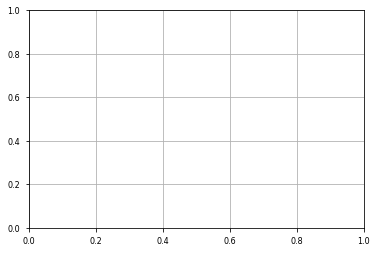

In [114]:
plt.gca().grid()

In [115]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=.25)

    return ax

In [116]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

In [117]:
nnsvm(plt.rcParams, -2)

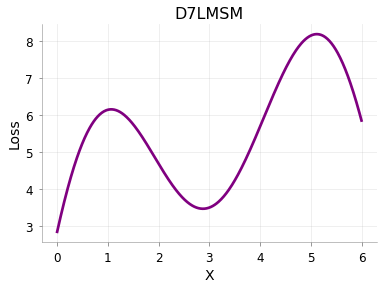

In [139]:
x = np.atleast_2d(np.linspace(0, 6, 600)).T
plt.plot(x, f(x), color='purple', label='GT')
#plt.plot(X, Y, color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Total loss")
plt.title("D7LMSM")
format_axes(plt.gca())
plt.show()

<AxesSubplot:title={'center':'Prior'}, xlabel='RFQ phase', ylabel='Gold content'>

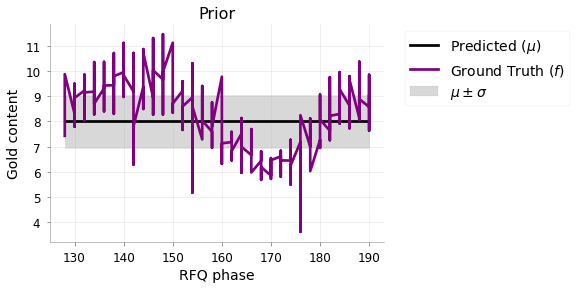

In [138]:
# kernel = Matern(length_scale=1.0)
# kernel = None

y_pred, var = 8*np.ones(X.shape).flatten(), 1.1*np.ones(X.shape).flatten()
sigma = np.sqrt(var).squeeze()

plt.plot(X, y_pred, 'k', label='Predicted ($\mu$)')
plt.plot(X, Y, 'purple', label=r'Ground Truth ($f$)')
plt.xlabel("RFQ phase")
plt.ylabel("Total loss")
plt.title("Prior")
plt.fill_between(X, y_pred+sigma, y_pred-sigma,
                 color='gray', 
                 alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())

In [120]:
train_X = np.atleast_2d([0.5, 0.12]).T
train_y = f(train_X)

In [128]:
def gp_creator(x, y, val = 5):
    # check sizes!!!
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

In [129]:
#train_X = np.atleast_2d([0.5]).T
#train_y = f(train_X).flatten()
train_X = df['RFQPAH_R']
train_Y = losses['D7LMSM']


gp = gp_creator(train_X, train_y)
# gp.fit(train_X, train_y)
# gp.optimize()
y_pred, var = [t.flatten() for t in gp.predict(x)]
sigma = np.sqrt(var).squeeze()

plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
plt.xlabel("X")
plt.title("Posterior")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=300, zorder=10, label='Last Added Point')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())

IndexError: tuple index out of range

 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.8/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in subtract
 /Users/rshara01-local/miniforge3/envs/rootenv/lib/python3.

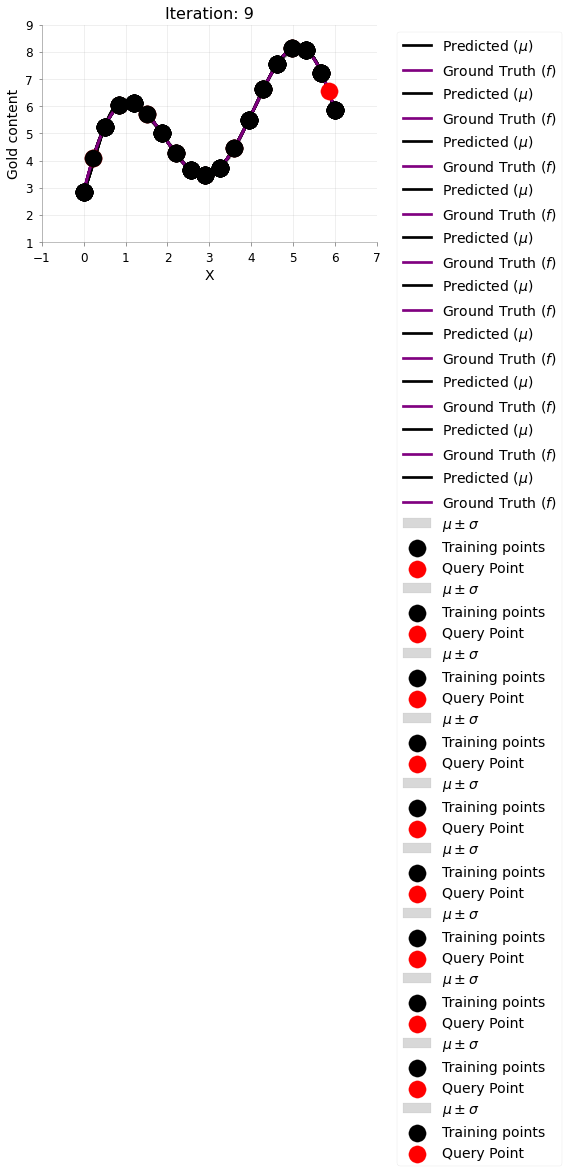

In [126]:
# Stopping criteria is 10 iterations
nnsvm(plt.rcParams, 2)
for i in range(10):
    # Fit on current train set
    gp = gp_creator(train_X, train_y)
#     gp.optimize(?)
    # predict on current pool set
    y_pred, var = [t.flatten() for t in gp.predict(x)]
    sigma = np.sqrt(var).squeeze()
    
    plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
    plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
    plt.xlabel("X")
    plt.ylabel("Gold content")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, 
                     color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X[:-1], train_y[:-1], color='black', s=300, zorder=10, label='Training points')
    plt.scatter(train_X[-1], train_y[-1], color='red', s=300, zorder=10, label='Query Point')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    plt.ylim((1, 9))
    plt.xlim((-1, 7))
    #plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

In [125]:
gp

GP_regression.,value,constraints,priors
constmap.C,5.0,,
Mat52.variance,1.0,+ve,
Mat52.lengthscale,1.0,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,
